In [7]:
!pip install -r requirements.txt

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)


# Import modules

In [8]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

/Users/hongseong-gyu/opt/anaconda3/envs/ddpm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting options

In [9]:
# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [10]:
# Training options
no_train = False
fashion = True
batch_size = 128
n_epochs = 20
lr = 0.001

In [11]:
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

# Utils

In [12]:
def show_images(images, title=""):
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx+1)
            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)
    plt.show()

In [13]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "images in the first batch")
        break

# Load data

In [14]:
transform = Compose(
    [
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2)
    ]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:11<00:00, 2202287.84it/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 96844.13it/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1153247.49it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9114511.18it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



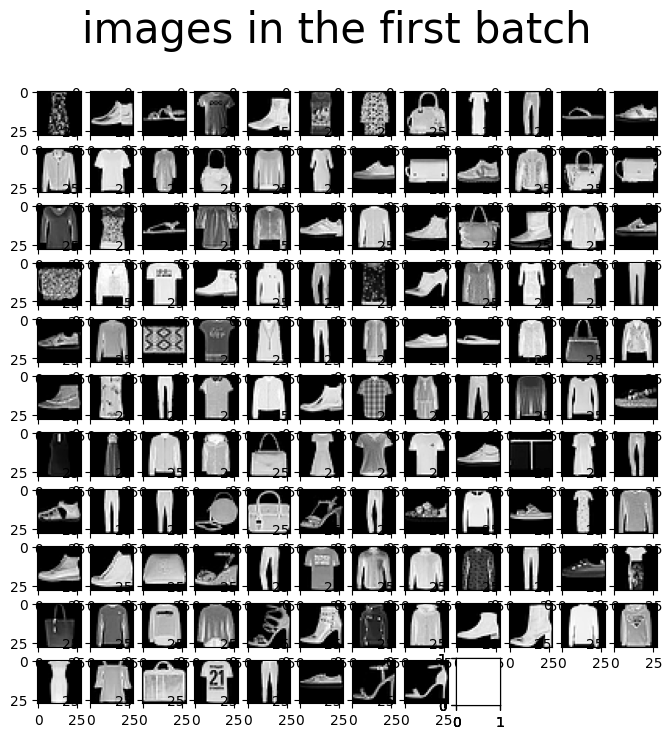

In [15]:
show_first_batch(loader)

# Getting device

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

# Define DDPM

In [24]:
class MyDDPM(nn.Module):
    def __init__(
        self,
        network,
        n_steps=200,
        min_beta=10**-4,
        max_beta=0.02,
        device=None,
        image_chw=(1, 28, 28)
    ) -> None:
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network
        self.betas = torch.linspace(
            start=min_beta,
            end=max_beta,
            steps=n_steps
        ).to(device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor(
            [
                torch.prod(self.alphas[:i+1]) for i in range(len(self.alphas))
            ]
        ).to(device=device)

    def forward(self, x0, t, eta=None):
        """
        Forward process (Diffusion)
        """
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]
        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)
        # q(xt|x0) = N (xt;√α¯tx0,(1 − α¯t)I)
        noisy = a_bar.sqrt().reshape(n, 1, 1, 1)*x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1)*eta
        return noisy

    def backward(self, x, t):
        """
        Reverse process
        """
        return self.network(x, t)

# Define UNet

In [25]:
def sinusoidal_embedding(n, d):
    # Return the standard positional embedding
    embedding = torch.tensor(
        [
            [
                i / 10_000 ** (2 * j / d) for j in range(d)
            ] for i in range(n)
        ]
    )
    sin_mask = torch.arange(start=0, end=n, step=2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])  # isn't it 1 - sin_mask of index?

    return embedding

In [26]:
class MyBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_c,
        out_c,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True
    ) -> None:
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(
            in_channels=in_c,
            out_channels=out_c,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.conv2 = nn.Conv2d(
            in_channels=out_c,
            out_channels=out_c,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(
        self,
        x
    ):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [27]:
class MyUNet(nn.Module):
    def __init__(
        self,
        n_steps=1000,
        time_emb_dim=100
    ) -> None:
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Sencond half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(
        self,
        x,
        t  # n_step
    ):
        t = self.time_embed(t)  # (n_steps, time_emb_dim) -> time_emb_dim
        n = len(x)

        # First half
        # x : (n, 1, 28, 28)
        # self.te1(t) : (1,)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # out1 : (n, 10, 28, 28)
        # self.down1(out1) : (n, 10, 14, 14)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # out2 : (n, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # out3 : (n, 40, 7, 7)

        # Bottleneck
        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))

        # Second half
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # out4 : (n, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # out4 : (n, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # out5 : (n, 40, 14, 14)
        out5 = self.b5(out5 + self.t5(t).reshape(n, -1, 1, 1))  # out5 : (n, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # out : (n, 20, 28, 28)
        # out : (n, 20, 28, 28)
        # self.te_out(t).reshape(n, -1, 1, 1) : (n, 20, 1, 1)
        # out + self.te_out(t).reshape(n, -1, 1, 1) : (n, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # out : (n, 10, 28, 28)
        out = self.conv_out(out)  # out : (n, 1, 28, 28)

        return out


    def _make_te(
        self,
        dim_in,
        dim_out
    ):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Instantiating the model

In [28]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
network = MyUNet(n_steps=n_steps)
ddpm = MyDDPM(
    network=network,
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device
)

In [29]:
sum(
    [
        p.numel() for p in ddpm.parameters()
    ]
)

606852

# Visualizing forward(diffusion) & backward process

In [31]:
def show_forward(ddpm, loader, device):
    """
    Showing the forward process
    """
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(
                    x0=imgs.to(device),
                    t=[int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]
                ),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [32]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """
    Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples
    """
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            # $\mu_{\theta}(x_t, t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \tilde \alpha_t}}\epsilon)$
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                # $x_{t-1} = \mu_{\theta}(x_t, t) + \sigma_t*z where z \thicksim N(0, I)$
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

# Training loop

In [35]:
def training_loop(
    ddpm,
    loader,
    n_epochs,
    optim,
    device,
    display=False,
    store_path="ddpm_model.pt"
):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=True, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch
            # a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(low=0, high=n_steps, size=(n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
    
        # Display images generated at this epoch
        if display:
            show_images(
                generate_new_images(
                    ddpm=ddpm,
                    device=device
                ),
                title=f"Images generated at epoch {epoch + 1}"
            )
        
        log_string = f"Loss at epoch {epoch + 1} : {epoch_loss:.3f}"

        # Stroing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"
        
        print(log_string)


In [37]:
# Training
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"
if not no_train:
    training_loop(
        ddpm=ddpm,
        loader=loader,
        n_epochs=n_epochs,
        optim=Adam(ddpm.parameters(), lr=lr),
        device=device,
        store_path=store_path
    )

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Placeholder storage has not been allocated on MPS device!